# $E_\text{peak} - E_\gamma$ correlation

Gamma-ray Bursts (GRBs) are known to have a jet structure from its jet break time ($t_\text{break}$ actually already in the shock, when $\theta_\text{jet} \sim \theta_\Gamma \sim 1/\Gamma$). Thus making $E_\text{iso}$ an inaccurate measure of their properties, since this is the _equivalent_ isotropic energy. Furthermore, it is not only the fact of having a relativistic jet, but also the beaming (relativistic aberration) effects that come with it. In this notebook, we are trying to extend the code from [E_peak_Eiso_errors.ipynb](https://github.cm/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_errors.ipynb), where we compute fit for the $E_\text{peak}-E_\text{iso}$ correlation.

Here, we want to compute $E_\gamma$ (the collimated energy) from $E_\text{iso}$. The collimation-corrected energy $E_\gamma$ is equal to the isotropic equivalent energy $E_\text{iso}$ times the collimation factor $f = 1 - \cos\theta_\text{jet}$.

This equation derives from the definition of the solid angle (see notes), with which actually w can derive a collimation factor being $f = \Omega_\text{jet}/\Omega_\text{sphere}$, where $\Omega$ is the solid angle ($\Omega_\text{sphere} = 8\pi$). However, since $\theta_\text{jet}$ if very small ($\theta_\text{jet} < 5\ \text{deg}$) one can approximate $1 - \cos\theta \sim \theta^2/2$.

I don't have measurements for the $\theta_\text{jet}$ angle yet, since the table I got from _Ghirlanda et al. 2008_ does not contain that column. However, we can begin drafting the code using synthetic data. With that aim we're going to define a list of jet half-opening angles as using `np.random.unifrom()` for the interval $\theta_\text{jet} \in \left[0, 0.08 \right]$ ($3\ \text{deg} \sim 0.05\ \text{rad}$)

In [19]:
# import required libraries and define data-reading-related functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# read data
df = pd.read_csv('table.csv')
Epeak = np.log10(df['Epeak'])  # keV
Epeak_err = df['Epeak_err'] / (df['Epeak'] * np.log(10))
Eiso = np.log10(df['Eiso'])  # ergs
Eiso_err = df['Eiso_err'] / (df['Eiso'] * np.log(10))

theta = np.random.uniform(0, 0.08, len(Eiso)) # create random synthetic data within bounds
theta_err = np.random.uniform(2.5e-4, 7.5e-4, len(Eiso)) # creat random error data within 1/100 of theta values

## TODO: add errors to $\theta_\text{jet}$ and to $E_\gamma$

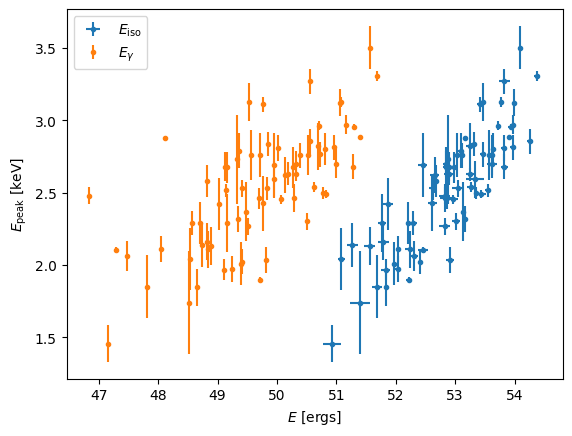

In [30]:
Egamma = np.log10(10**Eiso * (1-np.cos(theta)))
# Egamma_err = np.sqrt((1-np.cos(theta))*(Eiso_err**2) + (Eiso*np.sin(theta))*(theta_err**2))

plt.figure()
plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.', label=r'$E_\text{iso}$')
plt.errorbar(Egamma, Epeak, yerr=Epeak_err, fmt='.', label=r'$E_\gamma$')

plt.xlabel(r'$E$ [ergs]'); plt.ylabel(r'$E_\text{peak}$ [keV]'); plt.legend()

Next, as in the previous notebooks, we'll proceed to derive (two) correlations:
$$
\begin{align}
    \log E_\text{peak} = a \times \log E_\text{iso} + b\\
    \log E_\text{peak} = c \times \log E_\gamma +d\\
\end{align}
$$
The goal is to compare the parameter values for the best fit of the correlations and compare how correcting for the jet collimation has an effect. From the figure above, we can already infer that the relations will be different.

As in the other notebooks, we will use the vertical residuals least squares approach, following the equation:
$$\chi_r^2 = \text{dof}^{-1} \sum_i\frac{\left(E_\text{peak} - \text{model}\right)^2}{\sigma_{E_\text{peak}}^2}$$

In [11]:
def GoF(w,z,x,y,yerr=Epeak_err):
    """
    Goodness of fit following the reduced chi-squared formula with error propagation only in the y-axis (vertial residuals).
    :param w: slope parameter
    :param z: y-axis cut
    :param x: x-valuess (Eiso or Egamma)
    :param y: y-value (Epeak)
    :param yerr: uncertainties in y-value (Epeak_Err)
    :return: reduced chi-squared fit coefficients
    """
    model = w*x+z
    residuals = (y-model)**2
    variance = yerr**2
    dof = len(x)-2
    return np.sum(residuals/variance)/dof

In [25]:
a = np.linspace(.1,.9,100)
b = np.linspace(-1.,1.,100)
c = np.linspace(.1,.9,100)
d = np.linspace(-1.,1.,100)

Giso = np.zeros([len(a), len(b)])
Ggam = np.zeros([len(c), len(d)])

# barycenter method
ycm = np.sum(Epeak)/len(Epeak)
Eisocm = np.sum(Eiso)/len(Eiso)
Egamcm = np.sum(Egamma)/len(Egamma)

Epeak_bc = Epeak-ycm
Eiso_bc = Eiso-Eisocm
Egamma_bc = Egamma-Egamcm

if (len(a)!=len(c) or len(b)!=len(d)) or (len(a)!=len(c) and len(b)!=len(d)):
    raise ValueError('Parameter space not all same length')

#for i in range(len(a)): # since (a,c) and (b,d) have the same length, we can use a single iterator
    #for j in range(len(c)):
for i,j in tqdm(itertools.product(range(len(a)), range(len(b))), total=len(a)*len(b), desc="Computing fit..."):
        Giso[i,j] = GoF(a[i],b[j],x=Eiso_bc,y=Epeak_bc)
        Ggam[i,j] = GoF(c[i],d[j],x=Egamma_bc,y=Epeak_bc)

# extract best fit
min_chi_iso = np.min(Giso)
min_chi_gam = np.min(Ggam)
a_idx, b_idx = np.unravel_index(np.argmin(Giso), Giso.shape)
c_idx, d_idx = np.unravel_index(np.argmin(Ggam), Ggam.shape)
a_fit, b_fit, c_fit, d_fit = a[a_idx], b[b_idx], c[c_idx], d[d_idx]
print(f'Eiso: {min_chi_iso:.3f} {a_fit:.3f} {b_fit:.3f}')
print(f'Egam: {min_chi_gam:.3f} {c_fit:.3f} {d_fit:.3f}')

Computing fit...: 100%|██████████| 10000/10000 [00:02<00:00, 4451.64it/s]

Eiso: 14.558 0.553 -0.091
Egam: 38.832 0.359 -0.131


Text(0.5, 1.0, '$E_\\text{peak}-E_\\gamma$')

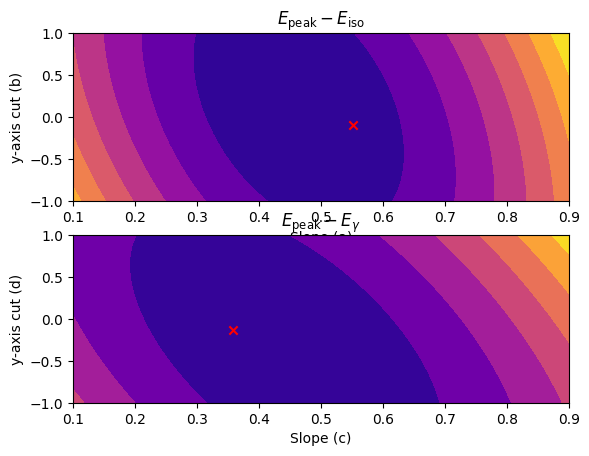

In [28]:
fig, ax = plt.subplots(2,1)

ax[0].contourf(a,b,Giso, cmap='plasma')#, levels=[min_chi_iso, min_chi_iso + 2.3, min_chi_iso + 4.61, min_chi_iso + 9.21])
#ax[0].set_colobar(label=r'$\chi_{red}^2$')
ax[0].scatter(a_fit, b_fit, marker='x', c='r')
ax[0].set_xlabel('Slope (a)'); ax[0].set_ylabel('y-axis cut (b)'); ax[0].set_title(r'$E_\text{peak}-E_\text{iso}$')

ax[1].contourf(a,b,Ggam,cmap='plasma')#,levels=[min_chi_gam, min_chi_gam + 2.3, min_chi_gam + 4.61, min_chi_gam + 9.21])
#ax[1].set_colobar(label=r'$\chi_{red}^2$')
ax[1].scatter(c_fit, d_fit, marker='x', c='r')
ax[1].set_xlabel('Slope (c)'); ax[1].set_ylabel('y-axis cut (d)'); ax[1].set_title(r'$E_\text{peak}-E_\gamma$')

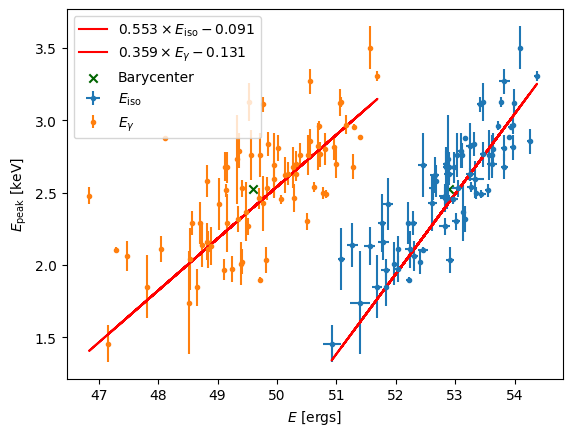

In [40]:
plt.figure()
plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.', label=r'$E_\text{iso}$')
plt.errorbar(Egamma, Epeak, yerr=Epeak_err, fmt='.', label=r'$E_\gamma$')

plt.plot(Eiso, ycm+b_fit+((Eiso-Eisocm)*a_fit), color='r', label=fr'${a_fit:.3f}\times E_\text{'{iso}'} {b_fit:.3f}$')
plt.scatter(Eisocm, ycm, color='darkgreen', marker='x')#, label='Barycenter')
plt.plot(Egamma, ycm+d_fit+((Egamma-Egamcm)*c_fit), color='r', label=fr'${c_fit:.3f}\times E_\gamma {d_fit:.3f}$')
plt.scatter(Egamcm, ycm, color='darkgreen', marker='x', label='Barycenter')

plt.xlabel(r'$E$ [ergs]'); plt.ylabel(r'$E_\text{peak}$ [keV]'); plt.legend()